In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pyBedGraph import BedGraph
from pybedtools import BedTool
import scipy.stats

In [2]:
def read_cf(directory, file_name):
    with open(directory + file_name) as f:
        chrom = {}
        for line in f:
            tmp = line.strip().split("\t")
            if tmp[0] != 'chrM':
                chrom[tmp[0]] = int(tmp[1])
    return chrom

In [11]:
def read_peak(directory, file_name):
    with open(directory + file_name) as f:
        seen = {}
        specific = []
        common = []
        for line in f:
            tmp = line.strip().split("\t")
            region = ','.join([tmp[0], tmp[1], tmp[2]])
            if region not in seen.keys():
                if tmp[3] != '.':
                    common.append([tmp[0], int(tmp[1]), int(tmp[2])])
                else:
                    specific.append([tmp[0], int(tmp[1]), int(tmp[2])])
                seen[region] = 1 # add region to seen list
    return specific, common

In [139]:
def plot_boxplot(dataset, dlabel, clr, tit, ylab, fig_name):
    fig = plt.figure(figsize = (8,6))
    medianprops = dict(linewidth = 3, color=clr)
    i=0
    boxprops = dict(linewidth = 1.5)
    toplot = [np.asarray([]) for i in range(len(dataset))]
    for d in dataset:
        #medianprops = dict(linewidth = 3, color=colcode[i])
        datax = toplot
        datax[i] = np.asarray(dataset[i])
        plt.boxplot(datax, widths = 0.6, medianprops = medianprops, boxprops = boxprops)
        i +=1
    plt.xticks([i for i in range(1, len(dataset)+1)], dlabel, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    #plt.ylim(bottom=2.5)
    plt.title(tit, fontsize = 18)
    plt.savefig(fig_name+'.pdf', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [57]:
def get_cov(interval_list, bgobj):
    tmpvals = []
    for x in interval_list:
        value = list(bgobj.stats(stat = 'max', intervals = [x]))
        tmpvals.append(value[0])
    return tmpvals

In [3]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [12]:
directory='/Users/kimm/Desktop/GM12878_files/'
#ctcf_cov='CDH0002NR_hg38_CTCF_FDR_0.1_pseudoGEM_5000_enrichTest_master_PASS.bedgraph'
ctcf_cov='GM12878-CTCF-pooled_comp_sing_FDR_0.2_PASS.bedgraph'
ctcf_peak='GM12878-CTCF-pooled_comp_sing_FDR_0.2_PASS_thresh70_merge3kb_peaks_GM12878-cohesin-pooled_comp_sing_FDR_0.2_PASS_thresh400_merge3kb_peaks_intersect_wao.bed'
#cohesin_cov='SHG0180-181-182NR_hg38_cohesin_FDR_0.1_pseudoGEM_5000_enrichTest_master_PASS.bedgraph'
cohesin_cov='GM12878-cohesin-pooled_comp_sing_FDR_0.2_PASS.bedgraph'
cohesin_peak='GM12878-cohesin-pooled_comp_sing_FDR_0.2_PASS_thresh400_merge3kb_peaks_GM12878-CTCF-pooled_comp_sing_FDR_0.2_PASS_thresh70_merge3kb_peaks_intersect_wao.bed'

In [5]:
chromfile = read_cf(directory, 'hg38.chrom.sizes')
#repet = BedTool(directory+'hg38PAM.sameChr.tx.sorted.legal.6To12Copies.within5kb_col1-4.bed')

In [6]:
bgctcf = BedGraph(directory+'hg38.chrom.sizes', directory+ctcf_cov)

In [7]:
bgcohesin = BedGraph(directory+'hg38.chrom.sizes', directory+cohesin_cov)

In [8]:
for key,val in chromfile.items():
    bgctcf.load_chrom_data(key)
    bgcohesin.load_chrom_data(key)

In [13]:
cohesin_spec, cohesin_comm = read_peak(directory, cohesin_peak)

In [16]:
ctcf_spec, ctcf_comm = read_peak(directory, ctcf_peak)

In [40]:
len(cohesin_comm)

16413

In [41]:
len(cohesin_spec)

10239

In [42]:
len(ctcf_comm)

16499

In [43]:
len(ctcf_spec)

2618

In [23]:
cohesin_comm_vals = list(bgcohesin.stats(stat = 'max', intervals = cohesin_comm))
cohesin_spec_vals = list(bgcohesin.stats(stat = 'max', intervals = cohesin_spec))
ctcf_comm_vals = list(bgctcf.stats(stat = 'max', intervals = ctcf_comm))
ctcf_spec_vals = list(bgctcf.stats(stat = 'max', intervals = ctcf_spec))

In [61]:
cohesin_comm_vals = get_cov(cohesin_comm, bgcohesin)
cohesin_spec_vals = get_cov(cohesin_spec, bgcohesin)
ctcf_comm_vals = get_cov(ctcf_comm, bgctcf)
ctcf_spec_vals = get_cov(ctcf_spec, bgctcf)

In [119]:
cohesin_stat = scipy.stats.mannwhitneyu([np.log10(x) for x in cohesin_comm_vals], [np.log10(x) for x in cohesin_spec_vals])

In [120]:
cohesin_title = "Cohesin \n  Common: median = " + str(int(np.median(cohesin_comm_vals))) + "; n = " + str(len(cohesin_comm_vals)) + "\n" + "Specific: median = " + str(int(np.median(cohesin_spec_vals))) + "; n = " + str(len(cohesin_spec_vals)) + "\n" + "Mann-Whitney stat = " + str(cohesin_stat[0]) + "; pval = " + str(cohesin_stat[1]) 

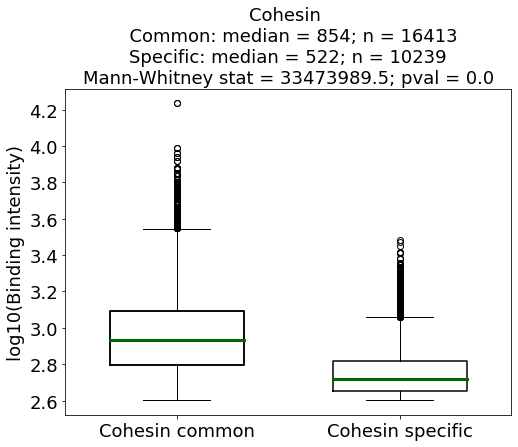

In [140]:
plot_boxplot([[np.log10(x) for x in cohesin_comm_vals], [np.log10(x) for x in cohesin_spec_vals]], ['Cohesin common', 'Cohesin specific'], '#006600', cohesin_title, 'log10(Binding intensity)', 'cohesin_common_vs_spec_boxplot')

In [131]:
np.log10(400)

2.6020599913279625

In [125]:
ctcf_stat = scipy.stats.mannwhitneyu([np.log10(x) for x in ctcf_spec_vals], [np.log10(x) for x in ctcf_comm_vals])

In [126]:
ctcf_title = "CTCF \n  Common: median = " + str(int(np.median(ctcf_comm_vals))) + "; n = " + str(len(ctcf_comm_vals)) + "\n" + "Specific: median = " + str(int(np.median(ctcf_spec_vals))) + "; n = " + str(len(ctcf_spec_vals)) + "\n" + "Mann-Whitney stat = " + str(ctcf_stat[0]) + "; pval = " + str(ctcf_stat[1]) 

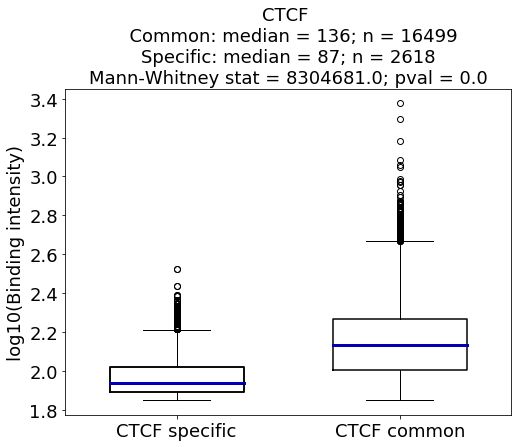

In [141]:
plot_boxplot([[np.log10(x) for x in ctcf_spec_vals], [np.log10(x) for x in ctcf_comm_vals]], ['CTCF specific', 'CTCF common'], '#0000B2', ctcf_title, 'log10(Binding intensity)', 'ctcf_common_vs_spec_boxplot')